In [150]:
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import pandas as pd
import contractions
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [93]:
df = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/common-e8332.appspot.com/o/95_reviews.csv?alt=media&token=0f30ab16-7754-4988-b64f-69ea4b4b12c7')
df.head()

,Unnamed: 0,reviews,labels
0,0,"Amazing movie, great acting!",1
1,1,Loved the plot and characters.,1
2,2,Best experience I've had!,1
3,3,Impressive direction and cast.,1
4,4,Heartwarming and emotional journey.,1


In [94]:
reviews = np.array(df['reviews'])
labels = np.array(df['labels'])

In [95]:
lemmatizer = WordNetLemmatizer()
# Preprocessing
def preprocess_review(review):

    review = contractions.fix(review)
    
    # Convert to lowercase
    review = review.lower()
    
    # Tokenize
    tokens = word_tokenize(review)
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

In [96]:
cleaned_reviews = []
# Process each review
for review in reviews:
    cleaned_reviews.append(preprocess_review(review))

In [97]:
cleaned_reviews[-5:]

[['emotionally', 'charged', 'powerful', 'film'],
 ['could', 'stop', 'thinking', 'ended'],
 ['predictable', 'formulaic', 'seen'],
 ['touching', 'heartwarming', 'experience'],
 ['failed', 'keep', 'interest', 'quite', 'bland']]

In [ ]:
# Loading the embedding
model_path = 'https://firebasestorage.googleapis.com/v0/b/common-e8332.appspot.com/o/GoogleNews-vectors-negative300-SLIM.bin?alt=media&token=ce5beeda-f8b4-4d27-99b1-0098b6128372'

# Load the Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [98]:
# Adding special tokens to embedding

# Define the embedding size (for the GoogleNews vectors, it's 300)
embedding_size = word2vec_model.vector_size

# Initialize the <unk> and <pad> vectors (either zero or random)
unk_vector = np.random.uniform(-0.25, 0.25, embedding_size)  # Random initialization
pad_vector = np.zeros(embedding_size)  # Zero vector for padding

# Add <unk> and <pad> to the model's vocabulary
word2vec_model.add_vector('<unk>', unk_vector)
word2vec_model.add_vector('<pad>', pad_vector)

c:\Users\chaud\AppData\Local\Programs\Python\Python312\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


299569

In [99]:
mean_sequence_length = np.array([len(s.split()) for s in reviews]).mean()
print("Mean Sequence Length:", mean_sequence_length)

Mean Sequence Length: 5.389473684210526


In [100]:
sequence_length = 10
# Replace words with indices based on vocabulary and pad sequences
indexed_reviews = []
for review in cleaned_reviews:
    indexed_review = []
    
    # Replace words with indices, use <unk> if word is not in vocabulary
    for word in review:
        if word in word2vec_model.key_to_index:
            indexed_review.append(word2vec_model.key_to_index[word])
        else:
            indexed_review.append(word2vec_model.key_to_index['<unk>'])  # Use <unk> if word is missing

    # Pad with <pad> token if the sequence is shorter than the sequence length
    if len(indexed_review) < sequence_length:
        indexed_review.extend([word2vec_model.key_to_index['<pad>']] * (sequence_length - len(indexed_review)))
    
    # Truncate to the maximum sequence length if too long
    indexed_reviews.append(indexed_review[:sequence_length])

# Convert to numpy array for consistency
indexed_reviews = np.array(indexed_reviews)

In [101]:
indexed_reviews[:2]

array([[  2756,   1083,    251,   2456, 299568, 299568, 299568, 299568,
        299568, 299568],
       [  2979,   4004,   1924, 299568, 299568, 299568, 299568, 299568,
        299568, 299568]])

In [102]:
X_train, X_test, y_train, y_test = train_test_split(indexed_reviews, labels, test_size=0.2, random_state=20, stratify=labels)

In [103]:
X_train.shape, X_test.shape

((76, 10), (19, 10))

In [104]:
class AdamOptimizer:
    def __init__(self, alpha, params, beta1=0.9, beta2=0.999, epsilon=10e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.moments = []
        self.epoch = 0
        if not params:
            raise Exception("Parameters can't be undefined!")
        for i in range(len(params)):
            self.moments.append(
                {
                    'V': np.zeros_like(params[i]),
                    'S': np.zeros_like(params[i])
                }
            )

    def update(self, params=[], grads=[]):
        params_len = len(params)
        grads_len = len(grads)
        if params_len != grads_len or params_len == 0:
            raise Exception("Empty or Inconsistant Parameters and Gradients List!")

        self.epoch += 1

        for i in range(grads_len):
            # Update biased first moment estimate
            self.moments[i]['V'] = self.beta1 * self.moments[i]['V'] + (1 - self.beta1) * grads[i]
            # Update biased second raw moment estimate (RMSProp part)
            self.moments[i]['S'] = self.beta2 * self.moments[i]['S'] + (1 - self.beta2) * np.square(grads[i])
            # Compute bias-corrected first moment estimate
            VdW_corrected = self.moments[i]['V'] / (1 - self.beta1 ** self.epoch)
            # Compute bias-corrected second raw moment estimate (RMSProp part)
            SdW_corrected = self.moments[i]['S'] / (1 - self.beta2 ** self.epoch)
            # Update parameters
            params[i] -= self.alpha * VdW_corrected / (np.sqrt(SdW_corrected) + self.epsilon)
        
        return params

In [105]:
class GRU:
    '''
    Specifications:
        * Only contains single GRU layer
        * GRU Layer Activation Function: tanh
    '''
    def __init__(self, units, seq_len, total_classes, total_features=None, embedding_matrix=None, lr=0.1):
        self.embedding_matrix = embedding_matrix
        self.lr = lr
        self.seq_len = seq_len
        self.total_classes = total_classes
        if self.embedding_matrix is not None:
            self.total_features = self.embedding_matrix.shape[1]
            self.get_input_matrix = self.get_input_matrix_from_embedding_matrix
        else:
            if not total_features:
                raise Exception("Define total features!")
            self.total_features = total_features
            self.get_input_matrix = self.get_input_matrix_from_3d_input
        self.out_vals = 1 if self.total_classes == 2 else self.total_classes
        self.units = units
        self.reset_weights_biases() # Initializing Weights and Biases
        if self.out_vals == 1:
            self.calc_loss = self.calc_bce
            self.calc_accuracy = self.calc_accuracy_for_bin_classification
            self.out_func = self.sigmoid
            self.loss = 'BCE'
        else:
            self.calc_loss = self.calc_cce
            self.calc_accuracy = self.calc_accuracy_for_mult_class_classification
            self.out_func = self.softmax
            self.loss = 'CCE'
        
        self.epoch = 0
    
    def sigmoid(self, z):
        return (1/(1+np.exp(-z)))
    
    def softmax(self, Z):
        num = np.exp(Z)
        den = np.sum(num, axis=0)
        return num/den
    
    def diag(self, array):
        flat_array = array.flatten()
        return np.diag(flat_array)
    
    def get_input_matrix_from_3d_input(self, input, idx):
        return input[idx, :, :]
    
    def get_input_matrix_from_embedding_matrix(self, input, idx):
        return self.embedding_matrix[input[idx,:]].T
    
    def predict(self, input):
        if input.ndim == 3:
            input = input.transpose(1, 2, 0)
        else:
            input = input.T
        total_input_examples = input.shape[-1]
        A = np.zeros((self.units, total_input_examples))
        Z = np.zeros_like(A)
        R = np.zeros_like(A)
        Ac = np.zeros_like(A)
        for seq_len_idx in range(self.seq_len):
            input_matrix = self.get_input_matrix(input, idx=seq_len_idx)    #Dim: total_features x M
            Z = self.sigmoid(self.W_iz.T @ input_matrix + self.W_hz @ A + self.b_z)
            R = self.sigmoid(self.W_ir.T @ input_matrix + self.W_hr @ A + self.b_r)
            Ac = np.tanh ( R * (self.W_h @ A) + self.W_i.T @ input_matrix + self.b_h )
            A = (1 - Z) * Ac + Z * A
        return self.out_func( self.w_o.T @ A + self.b_o ).T
    
    def forward_prop(self, input, return_pred=True):
        total_input_examples = input.shape[-1]
        self.A = np.zeros((self.seq_len+1, self.units, total_input_examples))
        self.Z = np.zeros((self.seq_len, self.units, total_input_examples))
        self.R = np.zeros_like(self.Z)
        self.Ac = np.zeros_like(self.Z)
        for seq_len_idx in range(self.seq_len):
            input_matrix = self.get_input_matrix(input, idx=seq_len_idx)    #Dim: total_features x M
            self.Z[seq_len_idx] = self.sigmoid(self.W_iz.T @ input_matrix + self.W_hz @ self.A[seq_len_idx] + self.b_z)
            self.R[seq_len_idx] = self.sigmoid(self.W_ir.T @ input_matrix + self.W_hr @ self.A[seq_len_idx] + self.b_r)
            self.Ac[seq_len_idx] = np.tanh ( self.R[seq_len_idx] * (self.W_h @ self.A[seq_len_idx]) + self.W_i.T @ input_matrix + self.b_h )
            self.A[seq_len_idx+1] = (1 - self.Z[seq_len_idx]) * self.Ac[seq_len_idx] + self.Z[seq_len_idx] * self.A[seq_len_idx]
        if return_pred:
            return self.out_func( self.w_o.T @ self.A[-1] + self.b_o )
        return
    
    def backward_prop(self, input, true_labels):
        dL_by_db_o = np.zeros((self.out_vals, 1))
        dL_by_dw_o = np.zeros((self.units, self.out_vals))
        dL_by_db_z = np.zeros((self.units, 1))
        dL_by_dW_iz = np.zeros((self.total_features, self.units))
        dL_by_dW_hz = np.zeros((self.units, self.units))
        dL_by_db_r = np.zeros((self.units, 1))
        dL_by_dW_ir = np.zeros((self.total_features, self.units))
        dL_by_dW_hr = np.zeros((self.units, self.units))
        dL_by_db_h = np.zeros((self.units, 1))
        dL_by_dW_i = np.zeros((self.total_features, self.units))
        dL_by_dW_h = np.zeros((self.units, self.units))
        y_pred = self.out_func( self.w_o.T @ self.A[-1] + self.b_o )
        temp_1 = y_pred - true_labels
        # b_o
        dL_by_db_o += np.sum(temp_1, axis=1).reshape(self.out_vals, 1)
        # w_o
        dL_by_dw_o += self.A[-1] @ temp_1.T
        temp_1 = self.w_o @ temp_1  # Dim: hxM
        # b_z
        hold = temp_1 * (self.A[-2] - self.Ac[-1]) * (self.Z[-1] * (1 - self.Z[-1]))
        dL_by_db_z += np.sum(hold, axis=1).reshape(self.units, 1)
        input_matrix = self.get_input_matrix(input, idx=-1)
        # W_iz
        dL_by_dW_iz += input_matrix @ hold.T
        # W_hz
        dL_by_dW_hz += hold @ self.A[-2].T
        # b_h
        temp_2 = temp_1 * (1 - self.Z[-1])
        hold = temp_2 * (1 - np.square(self.Ac[-1]))
        dL_by_db_h += np.sum(hold, axis=1).reshape(self.units, 1)
        # W_i
        dL_by_dW_i += input_matrix @ hold.T # Dim: total_features x units   # First word of sequence
        # W_h
        dL_by_dW_h += (hold * self.R[-1]) @ self.A[-2].T # Dim: units x units
        # b_r
        hold = hold * (self.W_h @ self.A[-2]) * (self.R[-1] * (1 - self.R[-1]))
        dL_by_db_r += np.sum(hold, axis=1).reshape(self.units, 1)
        # W_ir
        dL_by_dW_ir += input_matrix @ hold.T
        # W_hr
        dL_by_dW_hr += hold @ self.A[-2].T

        for seq_len_idx in range(1, self.seq_len):
            temp_1 = temp_1 * self.Z[-seq_len_idx]
            input_matrix = self.get_input_matrix(input, idx=-seq_len_idx-1)
            # b_z
            hold = temp_1 * (self.A[-seq_len_idx-2] - self.Ac[-seq_len_idx-1]) * (self.Z[-seq_len_idx-1] * (1 - self.Z[-seq_len_idx-1]))
            dL_by_db_z += np.sum(hold, axis=1).reshape(self.units, 1)
            # W_iz
            dL_by_dW_iz += input_matrix @ hold.T
            # W_hz
            dL_by_dW_hz += hold @ self.A[-seq_len_idx-2].T
            # b_h
            temp_2 = temp_1 * (1 - self.Z[-seq_len_idx-1])
            hold = temp_2 * (1 - np.square(self.Ac[-seq_len_idx-1]))
            dL_by_db_h += np.sum(hold, axis=1).reshape(self.units, 1)
            # W_i
            dL_by_dW_i += input_matrix @ hold.T # Dim: total_features x units   
            # W_h
            dL_by_dW_h += (hold * self.R[-seq_len_idx-1]) @ self.A[-seq_len_idx-2].T # Dim: units x units
            # b_r
            hold = hold * (self.W_h @ self.A[-seq_len_idx-2]) * (self.R[-seq_len_idx-1] * (1 - self.R[-seq_len_idx-1]))
            dL_by_db_r += np.sum(hold, axis=1).reshape(self.units, 1)
            # W_ir
            dL_by_dW_ir += input_matrix @ hold.T
            # W_hr
            dL_by_dW_hr += hold @ self.A[-seq_len_idx-2].T
        return dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h

    def update_w_sgd(self, batch_size, dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h):
        norm_1 = 1/(batch_size)
        norm_2 = norm_1 / self.seq_len
        self.w_o -= self.lr * norm_1 * dL_by_dw_o
        self.b_o -= self.lr * norm_1 * dL_by_db_o
        self.b_z -= self.lr * norm_2 * dL_by_db_z
        self.W_iz -= self.lr * norm_2 * dL_by_dW_iz
        self.W_hz -= self.lr * norm_2 * dL_by_dW_hz
        self.b_r -= self.lr * norm_2 * dL_by_db_r
        self.W_ir -= self.lr * norm_2 * dL_by_dW_ir
        self.W_hr -= self.lr * norm_2 * dL_by_dW_hr
        self.b_h -= self.lr * norm_2 * dL_by_db_h
        self.W_i -= self.lr * norm_2 * dL_by_dW_i
        self.W_h -= self.lr * norm_2 * dL_by_dW_h
        return
    
    def update_w_adam_optimizer(self, batch_size, dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h):
        norm_1 = 1/(batch_size)
        norm_2 = norm_1 / self.seq_len

        dL_by_db_o *= norm_1
        dL_by_dw_o *= norm_1
        dL_by_db_z *= norm_2
        dL_by_dW_iz *= norm_2
        dL_by_dW_hz *= norm_2
        dL_by_db_r *= norm_2
        dL_by_dW_ir *= norm_2
        dL_by_dW_hr *= norm_2
        dL_by_db_h *= norm_2
        dL_by_dW_i *= norm_2
        dL_by_dW_h *= norm_2
        self.b_o, self.w_o, self.b_z, self.W_iz, self.W_hz, self.b_r, self.W_ir, self.W_hr, self.b_h, self.W_i, self.W_h = self.optimizer.update(params=[self.b_o, self.w_o, self.b_z, self.W_iz, self.W_hz, self.b_r, self.W_ir, self.W_hr, self.b_h, self.W_i, self.W_h], grads=[dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h])
        return

    def reset_weights_biases(self):
        self.b_o = np.zeros((self.out_vals, 1))
        self.w_o = np.random.randn(self.units, self.out_vals) * np.sqrt(2 / (self.units + self.out_vals))
        self.b_z = np.zeros((self.units, 1))
        self.W_iz = np.random.randn(self.total_features, self.units) * np.sqrt(2 / (self.total_features + self.units))
        self.W_hz = np.random.randn(self.units, self.units) * np.sqrt(2 / (self.units + self.units))
        self.b_r = np.zeros((self.units, 1))
        self.W_ir = np.random.randn(self.total_features, self.units) * np.sqrt(2 / (self.total_features + self.units))
        self.W_hr = np.random.randn(self.units, self.units) * np.sqrt(2 / (self.units + self.units))
        self.b_h = np.zeros((self.units, 1))
        self.W_i = np.random.randn(self.total_features, self.units) * np.sqrt(2 / (self.total_features + self.units))
        self.W_h = np.random.randn(self.units, self.units) * np.sqrt(2 / (self.units + self.units))

    def calc_bce(self, y_pred, true_label):
        # Calculate the BCE for each example
        loss = - (true_label * np.log(y_pred) + (1 - true_label) * np.log(1 - y_pred))
        
        # Return the total loss (sum of all individual losses)
        return np.sum(loss)
        
    def calc_cce(self, y_pred, true_label):
        # Clip y_pred to avoid log(0) and very small values that may cause numerical instability
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        
        # Calculate the categorical cross-entropy for each example
        cce = -np.sum(true_label * np.log(y_pred), axis=0)
        
        # Calculate the mean loss over all examples
        total_loss = np.sum(cce)
        
        return total_loss
    
    def calc_accuracy_for_bin_classification(self, true_labels, predictions):
        wrong_decisions = np.sum( ((predictions <= 0.5) & (true_labels == 1)) | ((predictions > 0.5) & (true_labels == 0)) )
        total_examples = true_labels.shape[1]
        accuracy = (total_examples-wrong_decisions)/total_examples * 100
        return accuracy
    
    def calc_accuracy_for_mult_class_classification(self, true_labels, predictions):
        pred_indices = np.argmax(predictions, axis=0)
        true_indices = np.argmax(true_labels, axis=0)
        wrong_decisions = np.sum(pred_indices != true_indices)
        total_examples = true_indices.size
        accuracy = (total_examples-wrong_decisions)/total_examples * 100
        return accuracy
    
    def evaluate(self, X, labels, reshape=True):
        if reshape:
            if X.ndim == 3:
                X = X.transpose(1, 2, 0)
            else:
                X = X.T
            labels = labels.T
        # Check if the array is 1D
        if labels.ndim == 1:
            # Reshape to a column vector with shape (x, 1)
            labels = labels.reshape(1, labels.size)
        predictions = self.forward_prop(X)
        loss = self.calc_loss(predictions, labels)
        loss *= 1/X.shape[-1]
        accuracy = self.calc_accuracy(labels, predictions)

        return accuracy.item(), loss.item()
        
    def train(self, X_train, y_train, X_test, y_test, epochs, resume=False, verbose=True, adam_optimizer=False):
        if X_train.ndim == 3:
            X_train = X_train.transpose(1, 2, 0)
            X_test = X_test.transpose(1, 2, 0)
        else:
            X_train = X_train.T
            X_test = X_test.T
        y_train = y_train.T
        y_test = y_test.T
        if adam_optimizer:
            self.update = self.update_w_adam_optimizer
            self.optimizer = AdamOptimizer(self.lr, params=[self.b_o, self.w_o, self.b_z, self.W_iz, self.W_hz, self.b_r, self.W_ir, self.W_hr, self.b_h, self.W_i, self.W_h])
        else:
            self.update = self.update_w_sgd
        if not resume:
            self.epoch = 0
            self.reset_weights_biases()

        total_training_examples = X_train.shape[-1]
        epoch_idx = 0
        training_ds_loss_history = []
        testing_ds_loss_history = []
        while epoch_idx < epochs:
            epoch_idx += 1
            self.epoch +=1 
            self.forward_prop(X_train, return_pred=False)
            dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h = self.backward_prop(X_train, y_train)
            self.update(total_training_examples, dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h)
            if verbose:
                training_ds_accuracy, training_ds_loss = self.evaluate(X_train, y_train, reshape=False)
                testing_ds_accuracy, testing_ds_loss = self.evaluate(X_test, y_test, reshape=False)
                training_ds_loss_history.append(training_ds_loss)
                testing_ds_loss_history.append(testing_ds_loss)
                print(f"Epoch {self.epoch:03d} | "
                      f"Train Accuracy: {training_ds_accuracy:.2f}% | Train Loss ({self.loss}): {training_ds_loss:.4f} | "
                      f"Test Accuracy: {testing_ds_accuracy:.2f}% | Test Loss ({self.loss}): {testing_ds_loss:.4f}\n")
        return training_ds_loss_history, testing_ds_loss_history

In [143]:
gru = GRU(units=32, seq_len=sequence_length, embedding_matrix=word2vec_model.vectors, total_classes=2, lr=0.001)

In [ ]:
training_ds_loss_history, testing_ds_loss_history = gru.train(X_train, y_train, X_test, y_test, 150, adam_optimizer=True)

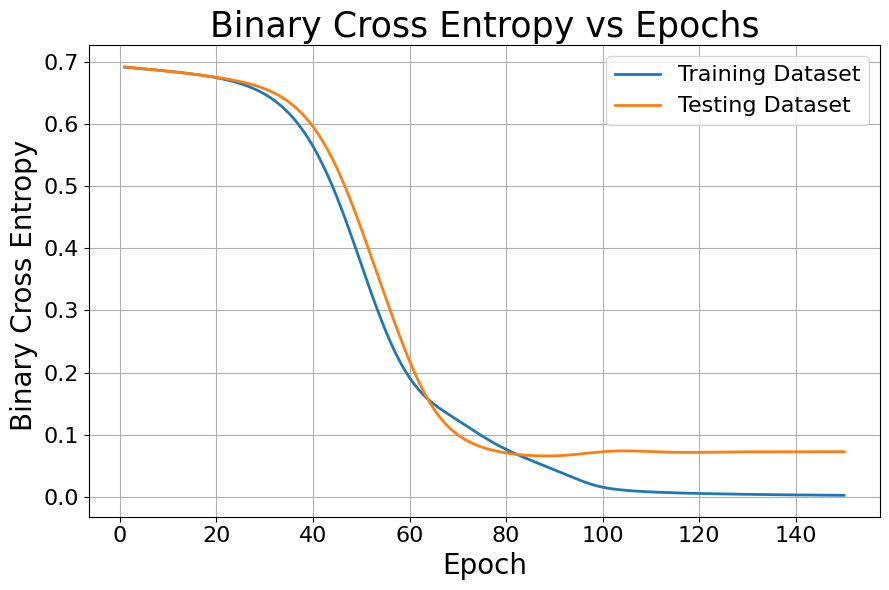

In [151]:
iterations = np.arange(1, len(training_ds_loss_history)+1)
plt.figure(figsize=(9, 6))
plt.plot(iterations, training_ds_loss_history, linewidth=2, label='Training Dataset')
plt.plot(iterations, testing_ds_loss_history, linewidth=2, label='Testing Dataset')
plt.title('Binary Cross Entropy vs Epochs', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Binary Cross Entropy ', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig('bce_gru.png', dpi=300)
plt.show()

In [152]:
accuracy_train, bce_train = gru.evaluate(X_train, y_train)
print(f"Training Dataset Accuracy: {accuracy_train:.2f}% | Training Dataset Loss (BCE): {bce_train:.4f}")

Training Dataset Accuracy: 100.00% | Training Dataset Loss (BCE): 0.0025


In [153]:
accuracy_test, bce_test = gru.evaluate(X_test, y_test)
print(f"Testing Dataset Accuracy: {accuracy_test:.2f}% | Testing Dataset Loss (BCE): {bce_test:.4f}")

Testing Dataset Accuracy: 94.74% | Testing Dataset Loss (BCE): 0.0727


In [154]:
# Generating Confusion matrix
y_pred = gru.predict(X_test)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:\n', cm, '\n')
print('True negative (Actually negative, classified as negative):', cm[0][0])
print('False positive (Actually negative, classified as positive):', cm[0][1])
print('False negative (Actually positive, classified as negative):', cm[1][0])
print('True positive (Actually positive, classified as positive):', cm[1][1])

Confusion Matrix:
 [[ 8  0]
 [ 1 10]] 

True negative (Actually negative, classified as negative): 8
False positive (Actually negative, classified as positive): 0
False negative (Actually positive, classified as negative): 1
True positive (Actually positive, classified as positive): 10


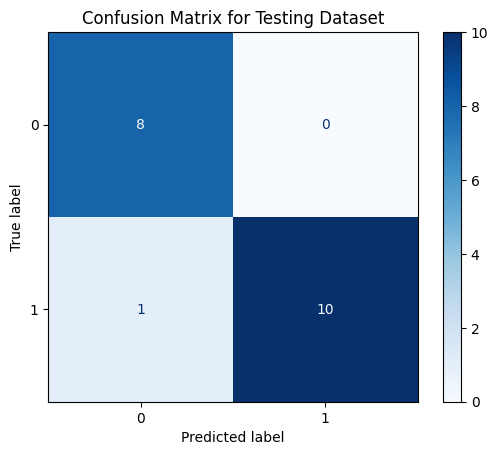

In [155]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Testing Dataset')
# plt.savefig('cm_rnn', dpi=300)
plt.show()

In [156]:
# Generating classification report from scikit-learn
cr = classification_report(y_test, y_pred_classes)
print('Classification Report\n\n', cr)

Classification Report

               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.91      0.95        11

    accuracy                           0.95        19
   macro avg       0.94      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19

